#Faktoranalyse
Der Parameter ```nutze``` (Zeile 4) kann auf ```Kreuz```,```Rechteck``` oder ```Männchen``` gesetzt werden, um den Datensatz auszuwählen.

(800, 2)


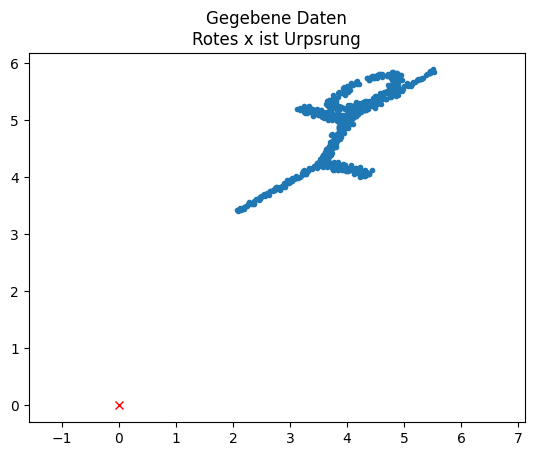

In [270]:
import numpy as np
import matplotlib.pyplot as plt

nutze = "Männchen" # Alternativ "Rechteck" oder "Kreuz"

base = np.linspace(-1,1, num=20)
base2 = np.linspace(0,1, num=10)

if nutze=="Rechteck":
    data = np.reshape(np.stack(np.meshgrid(np.linspace(-1,1, num=10), np.linspace(-1,1, num=10))), (-1, 2))
    sigma = 0.2
elif nutze=="Kreuz":
    data1 = np.column_stack([base, base])
    data2 = np.column_stack([base, -base])
    data = np.row_stack([data1, data2])
    sigma = 0.05
else:
    kopf = 0.5*np.column_stack([np.sin(np.pi*base), np.cos(np.pi*base)])+np.array([0,1])
    koerper = np.column_stack([np.zeros(len(base)),base ])-np.array([0,0.5])
    armlinks = np.column_stack((-base2, base2))
    armrechts = np.column_stack((base2, base2))
    beinlinks = np.column_stack((-base2, -base2))-np.array([0,1.5])
    beinrechts = np.column_stack((base2, -base2))-np.array([0,1.5])
    data = np.row_stack((kopf, koerper, armlinks, armrechts, beinlinks, beinrechts))
    sigma = 0.05

data_noise = np.row_stack([data+sigma*np.random.randn(*data.shape) for _ in range(10)])
data_noise = data_noise@np.array([[1.1,0.3],[0.3,0.5]])+np.array([4,5])
print(data_noise.shape)

plt.figure()
plt.plot(data_noise[:,0], data_noise[:,1], ".")
plt.plot([0],[0], "rx")
plt.title("Gegebene Daten\nRotes x ist Urpsrung")
plt.axis("equal")
plt.show()

## PCA

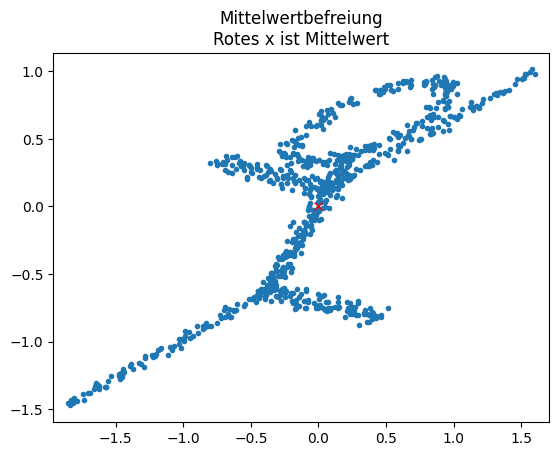

[[-0.70868676 -0.70552326]
 [ 0.70552326 -0.70868676]] [0.09563105 0.67791683]


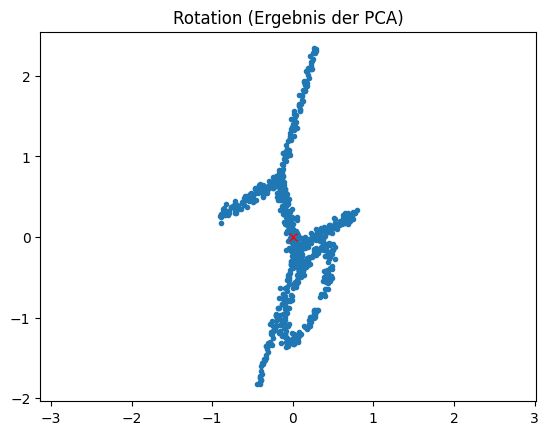

In [271]:
# Schritt 1: Mittelwertbefreiung
data_mean = data_noise-np.mean(data_noise, axis=0)

plt.figure()
plt.plot(data_mean[:,0], data_mean[:,1], ".")
plt.plot([0],[0], "rx")
plt.title("Mittelwertbefreiung\nRotes x ist Mittelwert")
plt.axis("equal")
plt.show()

# Schritt 2: Kovarianzmatrix bestimmen
covmat = data_mean.T@data_mean/len(data_mean)

# Schritt 3: Optimale Drehung durch Eigenwertzerlegung
eigv, rotation = np.linalg.eig(covmat)
print(rotation, eigv)
data_rotated = data_mean@rotation

plt.figure()
plt.plot(data_rotated[:,0], data_rotated[:,1], ".")
plt.plot([0],[0], "rx")
plt.title("Rotation (Ergebnis der PCA)")
plt.axis("equal")
plt.show()

## ICA

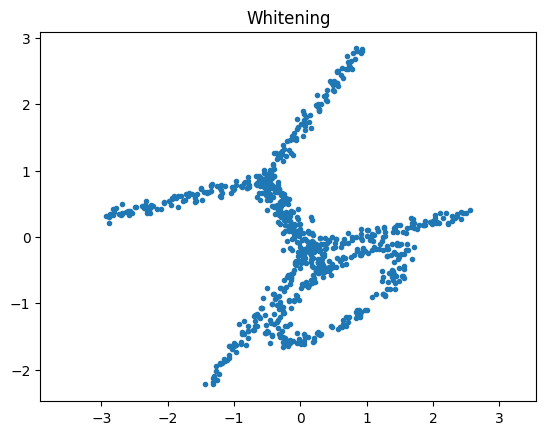

1.2482645093238738


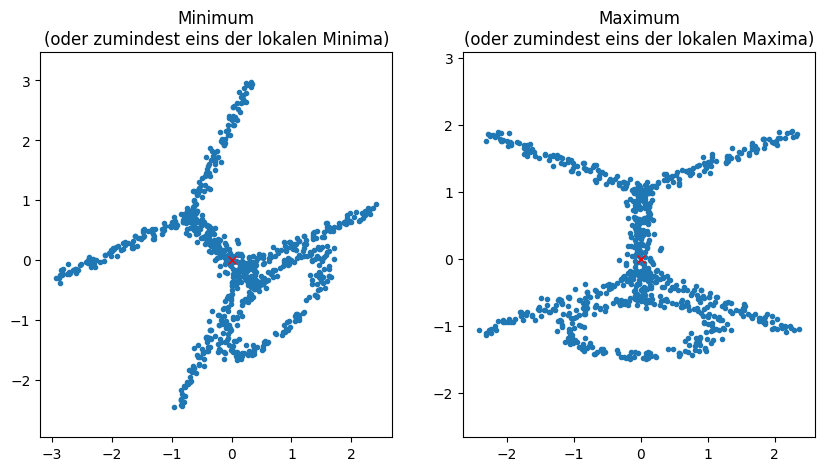

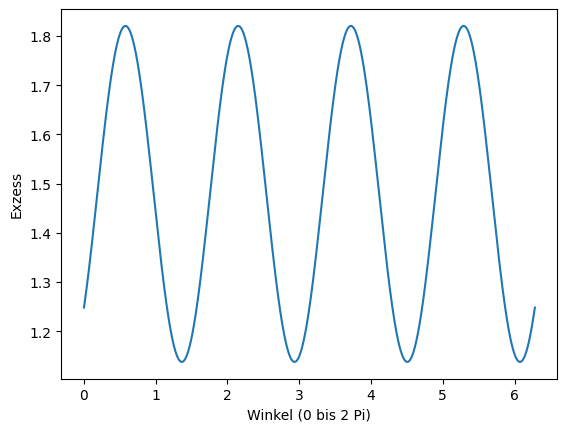

In [272]:
# ICA
# Schritt 1: PCA (siehe oben)

# Schritt 2: Whitening
data_white = data_rotated/np.sqrt(eigv)
plt.figure()
plt.plot(data_white[:,0], data_white[:,1], ".")
plt.title("Whitening")
plt.axis("equal")
plt.show()

# Schritt 3: Nichtgaußheit maximieren
def kurtosis(d):
    mean = np.mean(d, axis=0)
    std = np.std(d, axis=0)
    z = (d - mean) / std
    return np.abs(3-1/2*np.mean(z**4))
r_max = 0
r_min = 0
k_max = kurtosis(data_white)
k_min = k_max
print(k_max)
lokale_minima = []
lokale_maxima = []
log = []
ng_alt = 1e8
vz = 1
for winkel in np.linspace(0,2, 1000):
    w = winkel*np.pi
    r = np.array([[np.cos(w), -np.sin(w)], [np.sin(w), np.cos(w)]])
    data_r = data_white@r
    ng = kurtosis(data_r)
    if ng>k_max:
        r_max = r
        k_max = ng
    if ng<k_min:
        r_min = r
        k_min = ng
    if False:
        plt.figure()
        plt.plot(data_r[:,0], data_r[:,1], ".")
        plt.axis("equal")
        plt.title(ng)
        plt.show()
    log.append([w, ng])

log = np.array(log).T
data_ica1 = data_white@r_min#.T
data_ica2 = data_white@r_max#.T

plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.plot(data_ica1[:,0], data_ica1[:,1], ".")
plt.plot([0],[0], "rx")
plt.title("Minimum\n(oder zumindest eins der lokalen Minima)")
plt.axis("equal")
plt.subplot(1,2,2)
plt.plot(data_ica2[:,0], data_ica2[:,1], ".")
plt.plot([0],[0], "rx")
plt.title("Maximum\n(oder zumindest eins der lokalen Maxima)")
plt.axis("equal")
plt.show()

plt.figure()
plt.plot(log[0], log[1])
plt.xlabel("Winkel (0 bis 2 Pi)")
plt.ylabel("Exzess")
plt.show()